# Importing libraries

In [32]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.svm import SVC

sns.set(font_scale=1.3)

In [33]:
df_train = pd.read_csv('./emotions-dataset-for-nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('./emotions-dataset-for-nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('./emotions-dataset-for-nlp/test.txt', names=['Text', 'Emotion'], sep=';')

## Train dataset

<Axes: xlabel='Emotion', ylabel='count'>

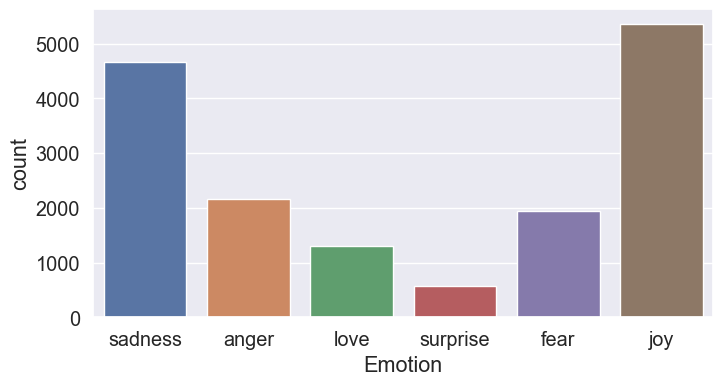

In [34]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train)

The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty 

## Test dataset

<Axes: xlabel='Emotion', ylabel='count'>

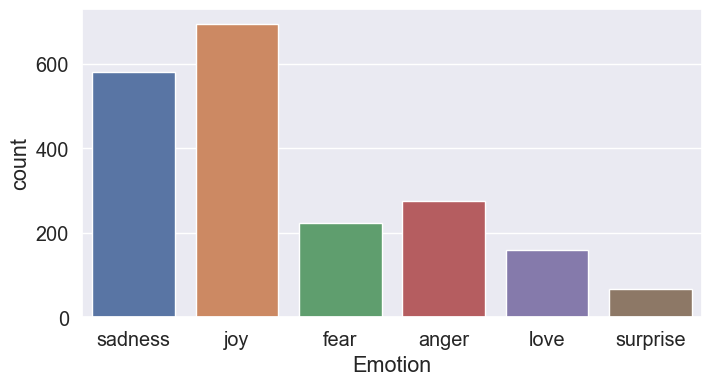

In [35]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test)


<Axes: xlabel='Emotion', ylabel='count'>

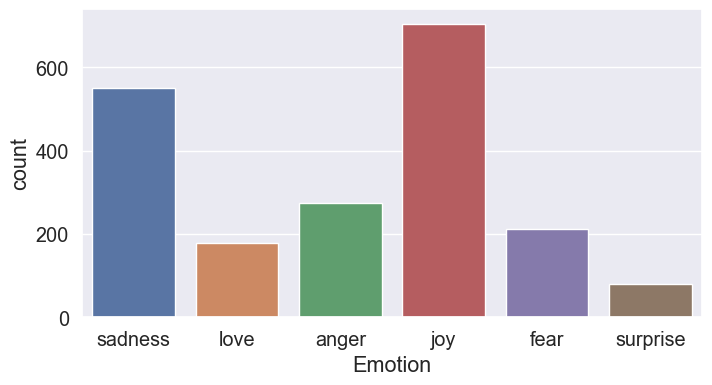

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val)

## Cleaning

In [37]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace(";","")
    text = re.sub('\\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : remove_numbers(text))
    df.Text=df.Text.apply(lambda text : remove_punctuations(text))
    df.Text=df.Text.apply(lambda text : remove_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= remove_numbers(sentence)
    sentence= remove_punctuations(sentence)
    sentence= remove_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

    

In [38]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")


'name mohamed tweet play egypt'

In [39]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [40]:
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [41]:
def train_model(model, data, targets):
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    text_clf.fit(data, targets)
    return text_clf

In [42]:
def get_F1(trained_model,X,y):
    predicted=trained_model.predict(X)
    f1=f1_score(y,predicted, average=None)
    return f1

**Training the Logistic Regression model on the Training set**


In [43]:
LR = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [44]:
lr_pred=LR.predict(['to be or not to be'])
lr_pred

array(['joy'], dtype=object)

In [45]:
lr_pred=LR.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, lr_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

log_reg_f1_Score = get_F1(LR,X_test,y_test)
pd.DataFrame(log_reg_f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.869 



,F1 score
sadness,0.860902
anger,0.825776
love,0.892452
surprise,0.698885
fear,0.917230
joy,0.626263


              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.89      0.77      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.85      0.59      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



<Axes: >

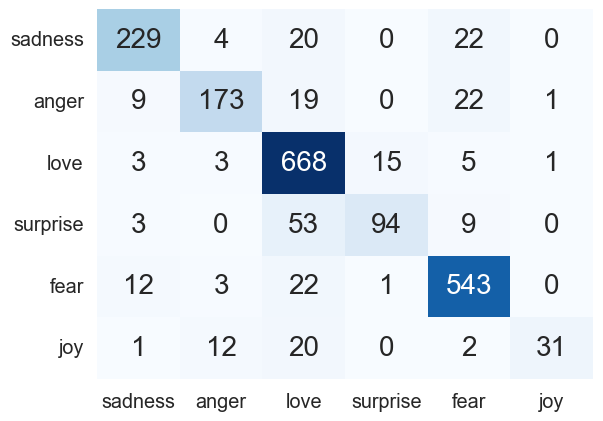

In [46]:
print(classification_report(y_test, lr_pred))

cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size':20}, yticklabels=df_train.Emotion.unique(), xticklabels=df_train.Emotion.unique())

**Training the Naive Bayes model on the Training set**


Accuracy:  0.6985 



<Axes: >

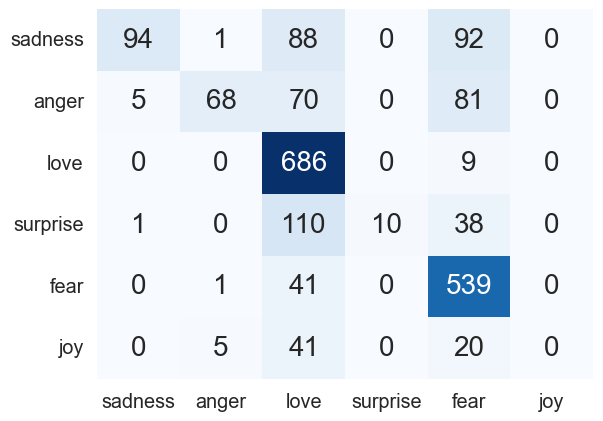

In [47]:
NB = train_model(MultinomialNB(), X_train, y_train)

nb_pred=NB.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_pred)
print('Accuracy: ', nb_accuracy,'\n')
nb_f1_score = get_F1(NB,X_test,y_test)
pd.DataFrame(nb_f1_score, index=df_train.Emotion.unique(), columns=['F1 score'])

cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size':20}, yticklabels=df_train.Emotion.unique(), xticklabels=df_train.Emotion.unique())

**Training the Support Vector Machine model on the Training set**


In [48]:
# SVM = train_model(SVC(random_state = 0), X_train, y_train)

In [53]:
# with open('svm.pkl', 'wb') as file:
#     pickle.dump(SVM, file)

In [54]:
with open('svm.pkl', 'rb') as file:
    loaded_SVM = pickle.load(file)

In [55]:
svm_pred=loaded_SVM.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_pred)
print('Accuracy: ', svm_accuracy,'\n')
svm_f1_score = get_F1(loaded_SVM,X_test,y_test)
pd.DataFrame(svm_f1_score, index=df_train.Emotion.unique(), columns=['F1 score']) 

confusion_matrix(y_test, svm_pred)

Accuracy:  0.868 



array([[226,   1,  22,   2,  24,   0],
       [ 10, 178,  17,   0,  18,   1],
       [  2,   5, 668,  13,   4,   3],
       [  1,   0,  59,  92,   7,   0],
       [ 13,   8,  19,   3, 537,   1],
       [  0,  14,  14,   0,   3,  35]], dtype=int64)

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.84      0.96      0.89       695
        love       0.84      0.58      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.88      0.53      0.66        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.86      2000



<Axes: >

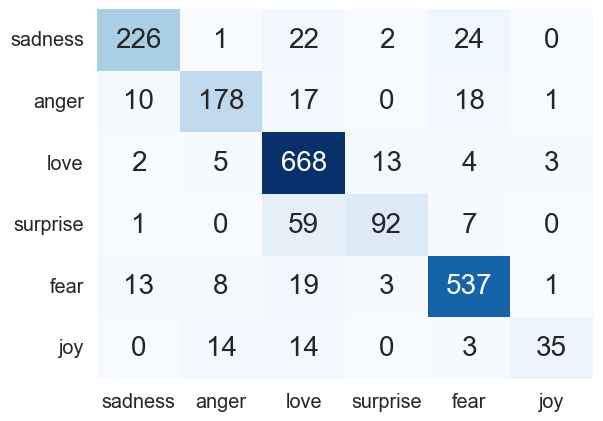

In [56]:
print(classification_report(y_test, svm_pred))

cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size':20}, yticklabels=df_train.Emotion.unique(), xticklabels=df_train.Emotion.unique())

## Results

In [57]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Naive Bayes','Support Vector Machine'],
    'Accuracy': [log_reg_accuracy.round(4),nb_accuracy.round(4) , svm_accuracy.round(4)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Logistic Regression,0.8690
1,Support Vector Machine,0.8680
2,Naive Bayes,0.6985
